In [1]:
import os
import sys
import gym
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf

from PPO.ppo import PPO
from A2C.a2c import A2C
from A3C.a3c import A3C
from DDQN.ddqn import DDQN
from DDPG.ddpg import DDPG

from keras.backend.tensorflow_backend import set_session
from keras.utils import to_categorical

from utils.atari_environment import AtariEnvironment
from utils.continuous_environments import Environment
from utils.networks import get_session

Using TensorFlow backend.


In [2]:
gym.logger.set_level(40)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
class attrdict(dict):
    def __init__(self, *args, **kwargs):
        dict.__init__(self, *args, **kwargs)
        self.__dict__ = self

In [4]:
args = attrdict(gpu=True, env='CartPole-v1', type='PPO', is_atari=False, 
                consecutive_frames=4, render=False, n_threads=16, nb_episodes=5_000,
               training_interval=30, batch_size=256, gather_stats=True, buffer_size=2048, epochs=10)

In [5]:
set_session(get_session())
summary_writer = tf.summary.FileWriter(args.type + "/tensorboard_" + args.env)

In [6]:
# Environment Initialization
if(args.is_atari):
    # Atari Environment Wrapper
    env = AtariEnvironment(args)
    state_dim = env.get_state_size()
    action_dim = env.get_action_size()
elif(args.type=="DDPG"):
    # Continuous Environments Wrapper
    env = Environment(gym.make(args.env), args.consecutive_frames)
    env.reset()
    state_dim = env.get_state_size()
    action_space = gym.make(args.env).action_space
    action_dim = action_space.high.shape[0]
    act_range = action_space.high
else:
    # Standard Environments
    env = Environment(gym.make(args.env), args.consecutive_frames)
    env.reset()
    state_dim = env.get_state_size()[0]
    action_dim = gym.make(args.env).action_space.n

In [7]:
# Pick algorithm to train
if(args.type=="DDQN"):
    algo = DDQN(action_dim, state_dim, args)
elif(args.type=="A2C"):
    algo = A2C(action_dim, state_dim, args.consecutive_frames)
elif(args.type=="PPO"):
    algo = PPO(action_dim, state_dim, args.consecutive_frames)
elif(args.type=="A3C"):
    algo = A3C(action_dim, state_dim, args.consecutive_frames, is_atari=args.is_atari)
elif(args.type=="DDPG"):
    algo = DDPG(action_dim, state_dim, act_range, args.consecutive_frames)






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
output (Dense)               (None, 2)                 258       
Total params: 17,410
Trainable params: 17,410
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
d

## train

In [8]:
# Train
rewards, actor_losses, critic_losses = algo.train(env, args, summary_writer)

Episode  1




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Episode  106
Episode  212
Episode  315
Episode  417
Episode  532
Episode  643
Episode  769
Episode  890
Episode  1011
Episode  1122
Episode  1233
Episode  1343
Episode  1461
Episode  1579
Episode  1687
Episode  1808
Episode  1935
Episode  2057
Episode  2176
Episode  2289
Episode  2393
Episode  2499
Episode  2605
Episode  2724
Episode  2847
Episode  2953
Episode  3076
Episode  3178
Episode  3273
Episode  3365
Episode  3454
Episode  3537
Episode  3624
Episode  3686
Episode  3751
Episode  3821
Episode  3885
Episode  3959
Episode  4020
Episode  4071
Episode  4127
Episode  4172
Episode  4212
Episode  4256
Episode  4302
Episode  4351
Episode  4396
Episode  4438
Episode  4478
Episode  4518
Episode  4557
Episode  4596
Episode  4632
Episode  4668
Episode  4704
Episode  4738
Episode  4776
Episode  4807
Episode  4842
Episode  4873
Episode  4897
Episode  4923
Episode  4950
Episode  4978


In [9]:
rewards = algo.batch_rewards

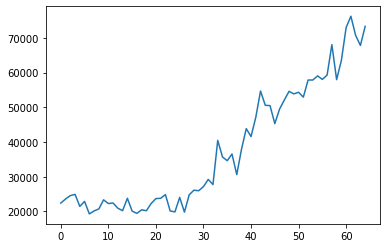

In [11]:
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.show()

In [12]:
algo.save_weights("saved_models/PPO")

## test

In [13]:
# Pick algorithm to test
if(args.type=="DDQN"):
    algo = DDQN(action_dim, state_dim, args, is_eval=True)
elif(args.type=="A2C"):
    algo = A2C(action_dim, state_dim, args.consecutive_frames, is_eval=True)
elif(args.type=="PPO"):
    algo = PPO(action_dim, state_dim, args.consecutive_frames, is_eval=True)
elif(args.type=="A3C"):
    algo = A3C(action_dim, state_dim, args.consecutive_frames, is_atari=args.is_atari, is_eval=True)
elif(args.type=="DDPG"):
    algo = DDPG(action_dim, state_dim, act_range, args.consecutive_frames, is_eval=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
output (Dense)               (None, 2)                 258       
Total params: 17,410
Trainable params: 17,410
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_

In [14]:
algo.load_weights("saved_models/PPO_LR_0.0001_actor.h5", "saved_models/PPO_LR_0.0001_critic.h5")

In [15]:
# Reset episode
num_test_int = 10
global_info = []

for i in range(num_test_int):
    time, cumul_reward, done = 0, 0, False
    old_state = env.reset_one()
    
    while not done:
        env.render()
        # Actor picks an action (following the policy)
        a = algo.policy_action(old_state)
        # Retrieve new state, reward, and whether the state is terminal
        new_state, r, done, _ = env.step_one(a)
        # Update current state
        old_state = new_state
        cumul_reward += r
        time += 1
        
        if done: 
            global_info.append({
                cumul_reward
            })

In [16]:
global_info

[{105.0},
 {112.0},
 {194.0},
 {122.0},
 {94.0},
 {79.0},
 {102.0},
 {168.0},
 {95.0},
 {229.0}]